# Brain Tumor Classification with Nucleotide Sequence Data Using Random Forest Classifier

## 0.  Import Required Libraries and Modules

In [1]:
# python fundamental libraries
import re
import glob

# for data processing
import numpy as np  # for arithmatic calculations
import pandas as pd # handling data with dataframe
import matplotlib.pyplot as plt  # plotting
from Bio.Seq import Seq, translate  # to deal with biological sequence
from Bio import SeqIO, pairwise2
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.SeqUtils import GC, molecular_weight, MeltingTemp
from sklearn.preprocessing import LabelEncoder  # string to numeric encoding
from sklearn.model_selection import train_test_split  # splitting data
from sklearn.decomposition import PCA  # dimensionality reduction
from sklearn.feature_extraction.text import TfidfVectorizer  # encoding

# building model
from sklearn.ensemble import RandomForestClassifier

# Evaluating model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

## 1.  Collection of Data

Source: National Center for Biotechnology Information (NCBI)  <br>
Url: https://www.ncbi.nlm.nih.gov/  <br>

__Types of Tumor with search keyword in NCBI:__  <br>
 [i] Metastatic: (Metastatic) AND "Homo sapiens"[porgn:__txid9606]  <br>
 [ii] Glioblastoma: (Glioblastoma) AND "Homo sapiens"[porgn:__txid9606]  <br>
 [iii] Astrocytoma: (Astrocytoma) AND "Homo sapiens"[porgn:__txid9606]  <br>

In [2]:
root_dir = "sequences/"
fnames = glob.glob(root_dir+"*.fasta")

print("Brain Tumor Fasta File Names:")
for fname in fnames:
    print("\t" + fname.split("/")[-1])

Brain Tumor Fasta File Names:
	Astrocytoma.fasta
	Glioblastoma.fasta
	Metastatic.fasta


## 2.  Data Preprocessing

### 2.1  Read Fasta and Convert into Dataframe

In [3]:
sequences = {}
frequency = {}
for fname in fnames:
    tumor = [str(record.seq.lower()) for record in SeqIO.parse(fname, 'fasta')]
    no_of_seq = len(tumor)
    tumor_name = fname.split("/")[-1].split(".fa")[0]
    sequences[tumor_name] = sorted(tumor, key=len)
    frequency[tumor_name] = no_of_seq

In [4]:
total = 0
for tumor_name, no_of_seq in frequency.items():
    print(f"{tumor_name} : {no_of_seq}")
    total += no_of_seq
print(f"Total Sequences: {total}")

Astrocytoma : 3538
Glioblastoma : 5655
Metastatic : 7127
Total Sequences: 16320


In [5]:
tumors = list(frequency.keys())
label = LabelEncoder()
labels = label.fit_transform(tumors)
label_dict = {i:j for i, j in zip(label.classes_, labels)}
print(label_dict)

{'Astrocytoma': 0, 'Glioblastoma': 1, 'Metastatic': 2}


In [6]:
tumor_sequences = []
classes = []
for tumor in tumors:
    tumor_sequences.extend(sequences[tumor])
    classes.extend([label_dict[tumor]]*frequency[tumor])

In [7]:
tumor_data = {'sequences': tumor_sequences, 'class': classes}
tumor_data = pd.DataFrame.from_dict(tumor_data)
tumor_data.head()

,sequences,class
0,ccccccaccaccacca,0
1,aggcccacccggcccc,0
2,ccccccaccaccacca,0
3,aggcccacccggcccc,0
4,ccgggggggcccccggggg,0


### 2.2  Feature Extraction

#### 2.2.1  Extraction of k-mer

In [8]:
def kmers(sequence, size=5):
    return " ".join([sequence[x:x+size] for x in range(len(sequence) - size + 1)])

In [9]:
kmers("ATCGGCTAGCTAGGATCG", 6)

'ATCGGC TCGGCT CGGCTA GGCTAG GCTAGC CTAGCT TAGCTA AGCTAG GCTAGG CTAGGA TAGGAT AGGATC GGATCG'

In [10]:
tumor_data["kmers"] = tumor_data["sequences"].apply(kmers)

#### 2.2.2  Extraction of open reading frames (orf)

In [11]:
def extract_orfs(sequence):
    pattern = re.compile(r"(?:atg)(?:[acgt]{3})*?(?=taa|tag|tga)", re.I)
    return re.findall(pattern, sequence)

In [12]:
extract_orfs("ATGGCTAGCTAGGATCG")

['ATGGCTAGC']

In [13]:
tumor_data["orfs"] = tumor_data["sequences"].apply(extract_orfs)

#### 2.2.3  Extraction of nucleotide compositions

In [14]:
def nuc_comp(seq):
    seq = seq.upper()
    N = len(seq)
    return pd.Series([seq.count("A")/N, seq.count("C")/N, seq.count("G")/N, seq.count("T")/N])

In [15]:
nuc_comp("ATGGCTAGCTAGGATCG")

0    0.235294
1    0.176471
2    0.352941
3    0.235294
dtype: float64

In [16]:
tumor_data[['As', 'Cs', 'Gs', 'Ts']] = tumor_data["sequences"].apply(nuc_comp)

#### 2.2.4  Extraction of di-nucleotide composition

In [17]:
def di_comp(seq):
    seq = seq.upper()
    n = 0
    #di_nuc = {"".join(p) : 0 for p in permutations("ACGT", 2)}
    di_nuc = {x+y : 0 for x in "ACGT" for y in "ACGT"}
    for i in range(len(seq)-1):
        dimer = seq[i:i+2]
        if "N" not in dimer:
            n += 1
            di_nuc[dimer] += 1
    di_nuc = {d : c/n for d, c in di_nuc.items()}
    di_nuc = dict(sorted(di_nuc.items(), key=lambda x: x[0].lower()))
    return pd.Series(list(di_nuc.values()))

In [18]:
di_comp("ATGGCTAGCTAGGATCG")

0     0.0000
1     0.0000
2     0.1250
3     0.1250
4     0.0000
5     0.0000
6     0.0625
7     0.1250
8     0.0625
9     0.1250
10    0.1250
11    0.0000
12    0.1250
13    0.0625
14    0.0625
15    0.0000
dtype: float64

In [19]:
di_mers = sorted([x+y for x in "ACGT" for y in "ACGT"])
tumor_data[di_mers] = tumor_data["sequences"].apply(di_comp)

In [20]:
print(di_mers)

['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT']


#### 2.2.5  Extraction of tri-nucleotide composition

In [21]:
def tri_comp(seq):
    seq = seq.upper()
    n = 0
    tri_nuc = {x+y+z : 0 for x in "ACGT" for y in "ACGT" for z in "ACGT"}
    for i in range(len(seq)-2):
        trimer = seq[i:i+3]
        if "N" not in trimer:
            n += 1
            tri_nuc[trimer] += 1
    tri_nuc = {t : c/n for t, c in tri_nuc.items()}
    tri_nuc = dict(sorted(tri_nuc.items(), key=lambda x: x[0].lower()))
    return pd.Series(list(tri_nuc.values()))

In [22]:
print(list(tri_comp("ATGGCTAGCTAGGATCG")))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06666666666666667, 0.06666666666666667, 0.0, 0.0, 0.06666666666666667, 0.06666666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.13333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06666666666666667, 0.0, 0.0, 0.0, 0.13333333333333333, 0.06666666666666667, 0.06666666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.13333333333333333, 0.0, 0.0, 0.0, 0.06666666666666667, 0.0, 0.0, 0.0, 0.06666666666666667, 0.0, 0.0, 0.0, 0.0, 0.0]


In [23]:
tri_mers = sorted([x+y+z for x in "ACGT" for y in "ACGT" for z in "ACGT"])
tumor_data[tri_mers] = tumor_data["sequences"].apply(tri_comp)

In [24]:
print(tri_mers)

['AAA', 'AAC', 'AAG', 'AAT', 'ACA', 'ACC', 'ACG', 'ACT', 'AGA', 'AGC', 'AGG', 'AGT', 'ATA', 'ATC', 'ATG', 'ATT', 'CAA', 'CAC', 'CAG', 'CAT', 'CCA', 'CCC', 'CCG', 'CCT', 'CGA', 'CGC', 'CGG', 'CGT', 'CTA', 'CTC', 'CTG', 'CTT', 'GAA', 'GAC', 'GAG', 'GAT', 'GCA', 'GCC', 'GCG', 'GCT', 'GGA', 'GGC', 'GGG', 'GGT', 'GTA', 'GTC', 'GTG', 'GTT', 'TAA', 'TAC', 'TAG', 'TAT', 'TCA', 'TCC', 'TCG', 'TCT', 'TGA', 'TGC', 'TGG', 'TGT', 'TTA', 'TTC', 'TTG', 'TTT']


#### 2.2.6  Extraction of protein compositions

In [25]:
def prot_comp(seq):
    seq = seq.upper()
    # create a ProteinAnalysis object for the protein sequence
    protein_analysis = ProteinAnalysis(seq)
    # get the amino acid composition of the protein
    if seq:
        aa_comp = protein_analysis.get_amino_acids_percent()
        return pd.Series(list(dict(sorted(aa_comp.items(), key=lambda x: x[0].lower())).values()))
    return pd.Series([0]*20)

In [26]:
print(prot_comp("MAAFCGNMFVEPGEQCDCGFLDDCVDPCCDSLTCQLRPGAQCASDG"))

0     0.086957
1     0.173913
2     0.130435
3     0.043478
4     0.065217
5     0.108696
6     0.000000
7     0.000000
8     0.000000
9     0.065217
10    0.043478
11    0.021739
12    0.065217
13    0.065217
14    0.021739
15    0.043478
16    0.021739
17    0.043478
18    0.000000
19    0.000000
dtype: float64


In [27]:
tumor_data["protein"] = tumor_data["sequences"].apply(translate)
aa = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
tumor_data[aa] = tumor_data["protein"].apply(prot_comp)

/home/ikraminf/anaconda3/lib/python3.9/site-packages/Bio/Seq.py:2979: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(
/tmp/ipykernel_4774/1372634742.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tumor_data[aa] = tumor_data["protein"].apply(prot_comp)
/tmp/ipykernel_4774/1372634742.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tumor_data[aa] = tumor_data["protein"].apply(prot_

#### 2.2.7  Extraction of GC percentage and Melting Temperature

In [28]:
tumor_data["gc"] = tumor_data["sequences"].apply(GC)
tumor_data["meltT"] = tumor_data["sequences"].apply(MeltingTemp.Tm_NN)

/tmp/ipykernel_4774/3785024045.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tumor_data["gc"] = tumor_data["sequences"].apply(GC)
/tmp/ipykernel_4774/3785024045.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tumor_data["meltT"] = tumor_data["sequences"].apply(MeltingTemp.Tm_NN)


In [29]:
tumor_data.head()

,sequences,class,kmers,orfs,As,Cs,Gs,Ts,AA,AC,...,P,Q,R,S,T,V,W,Y,gc,meltT
0,ccccccaccaccacca,0,ccccc ccccc cccca cccac ccacc cacca accac ccac...,[],0.250,0.750000,0.000000,0.0,0.0,0.200000,...,0.4,0.0,0.0,0.0,0.6,0.0,0.0,0.0,75.0,54.581024
1,aggcccacccggcccc,0,aggcc ggccc gccca cccac ccacc caccc acccg cccg...,[],0.125,0.625000,0.250000,0.0,0.0,0.066667,...,0.4,0.0,0.4,0.0,0.2,0.0,0.0,0.0,87.5,60.993016
2,ccccccaccaccacca,0,ccccc ccccc cccca cccac ccacc cacca accac ccac...,[],0.250,0.750000,0.000000,0.0,0.0,0.200000,...,0.4,0.0,0.0,0.0,0.6,0.0,0.0,0.0,75.0,54.581024
3,aggcccacccggcccc,0,aggcc ggccc gccca cccac ccacc caccc acccg cccg...,[],0.125,0.625000,0.250000,0.0,0.0,0.066667,...,0.4,0.0,0.4,0.0,0.2,0.0,0.0,0.0,87.5,60.993016
4,ccgggggggcccccggggg,0,ccggg cgggg ggggg ggggg ggggg ggggc gggcc ggcc...,[],0.000,0.368421,0.631579,0.0,0.0,0.000000,...,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,70.434487


###  2.3  Encoding

In [30]:
# encoding for kmers dataframe
tfidf1 = TfidfVectorizer()
X1 = pd.DataFrame(tfidf1.fit_transform(tumor_data['kmers']).toarray())
X1.head()

,0,1,2,3,4,5,6,7,8,9,...,2956,2957,2958,2959,2960,2961,2962,2963,2964,2965
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
# keep those columns having greater than 10 unique values in samples
nunique = X1.nunique()
X1 = X1.drop(nunique[nunique <= 10].index, axis=1)

In [32]:
# encoding for orfs dataframe
tfidf2 = TfidfVectorizer()
X2 = pd.DataFrame(tfidf2.fit_transform(map(" ".join, tumor_data['orfs'])).toarray())
X2

,0,1,2,3,4,5,6,7,8,9,...,12381,12382,12383,12384,12385,12386,12387,12388,12389,12390
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16315,0.331451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16316,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16317,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16318,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
# keep those columns having greater than 10 unique values in samples
nunique = X2.nunique()
X2 = X2.drop(nunique[nunique <= 10].index, axis=1)
X2

,0,1,488,1226,1683,1878,2479,2675,3022,3260,...,9399,9585,9865,10111,10539,10935,11166,11420,11627,11872
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16315,0.331451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16316,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16317,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16318,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
# add the two encoded dataframes together
chunk_size = 2000
chunks = []
N = X1.shape[1] + X2.shape[1]
for i in range(0, len(X1), chunk_size):
    chunk1 = X1.iloc[i:i+chunk_size]
    chunk2 = X2.iloc[i:i+chunk_size]
    concat_chunk = pd.concat([chunk1, chunk2], axis=1)
    chunks.append(concat_chunk)
    
X = pd.concat(chunks, axis=0)
X.columns = range(N)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,1565,1566,1567,1568,1569,1570,1571,1572,1573,1574
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
# concat other features with the above dataframe
cols = ['As','Cs','Gs','Ts','gc','meltT'] + aa + di_mers + tri_mers
X = pd.concat([X, tumor_data[cols]], axis=1)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2.4  Dimensionality Reduction: PCA

In [36]:
# Create PCA object with maximum number of components
pca = PCA(n_components=50)

# Fit PCA to the data
X = pca.fit_transform(X)

/home/ikraminf/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


### 2.5  Data Splitting

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, tumor_data['class'], test_size=0.20, random_state=1)

In [38]:
X_train

array([[-1.26058587e+01, -2.70229017e+00, -2.44818683e-01, ...,
         3.14184235e-02, -2.51135281e-02,  1.61708730e-02],
       [ 1.27852269e+01, -1.21504108e+00, -4.55179439e-02, ...,
         1.46276474e-02,  7.59835935e-03,  1.18044478e-02],
       [ 2.36094947e+00, -2.08971514e+00, -1.96438686e-01, ...,
        -1.78997952e-03, -6.60042784e-02, -2.68750263e-03],
       ...,
       [-1.97654007e+01, -1.44779180e+00, -2.52261940e-01, ...,
        -3.01434926e-02, -7.20596617e-03, -3.52013831e-02],
       [ 2.16825086e+01,  1.30425668e+00,  4.14899299e-02, ...,
         7.46168904e-03, -2.08033097e-02,  3.20257525e-02],
       [ 7.92975667e+00, -2.07349316e+00,  3.41737440e-01, ...,
         2.19678538e-02,  2.49625158e-02,  4.82427320e-03]])

In [39]:
X_test

array([[-4.78712851e+01,  3.25904597e+00,  1.34522738e+00, ...,
        -6.97729674e-02,  9.41423937e-02, -7.52591922e-02],
       [-3.84011160e+00, -1.20863649e+00,  3.99637594e-01, ...,
        -1.11460951e-01,  1.98667408e-01,  5.99520647e-02],
       [ 4.00279698e+00, -2.90791717e+00, -8.38903301e-02, ...,
        -1.00840670e-02, -4.33700641e-02, -1.01490292e-03],
       ...,
       [-2.47808600e+01, -2.30327454e+00,  5.88826142e-01, ...,
        -1.94732701e-02,  1.36376895e-02, -1.35515188e-04],
       [ 1.32712027e+01, -3.73477488e+00, -8.04155951e-02, ...,
         2.85624765e-02, -1.03987818e-02,  2.15677927e-02],
       [ 1.32418468e+00, -2.12211481e+00, -1.63995771e-01, ...,
         3.40508512e-02, -5.74815878e-02,  3.77324512e-03]])

### 2.6  Data Normalization

In [40]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [41]:
X_train

array([[-0.96712702, -0.54088806, -0.91544591, ...,  0.65940128,
        -0.53561425,  0.34251836],
       [ 0.98690093, -0.24164519, -0.16179909, ...,  0.30469708,
         0.16105381,  0.24953158],
       [ 0.18467727, -0.41763452, -0.73249912, ..., -0.04212435,
        -1.40646829, -0.05908698],
       ...,
       [-1.51810564, -0.28847594, -0.94359226, ..., -0.6410907 ,
        -0.15423526, -0.75149805],
       [ 1.6716112 ,  0.26525166,  0.16721729, ...,  0.15331662,
        -0.44381913,  0.68016167],
       [ 0.61323732, -0.41437057,  1.3025898 , ...,  0.45975853,
         0.53085983,  0.10088275]])

In [42]:
X_test

array([[-3.68105703e+00,  6.58566239e-01,  5.09724208e+00, ...,
        -1.47826111e+00,  2.00419001e+00, -1.60456358e+00],
       [-2.92539292e-01, -2.40356550e-01,  1.52153664e+00, ...,
        -2.35891740e+00,  4.23026879e+00,  1.27487652e+00],
       [ 3.11029332e-01, -5.82261362e-01, -3.06902552e-01, ...,
        -2.17336478e-01, -9.24425361e-01, -2.34675292e-02],
       ...,
       [-1.90408156e+00, -4.60603872e-01,  2.23694466e+00, ...,
        -4.15682860e-01,  2.89673973e-01, -4.74021058e-03],
       [ 1.02430029e+00, -7.48629774e-01, -2.93762997e-01, ...,
         5.99069556e-01, -2.22232951e-01,  4.57450413e-01],
       [ 1.04890713e-01, -4.24153516e-01, -6.09817689e-01, ...,
         7.15011161e-01, -1.22495977e+00,  7.85002047e-02]])

## 3.  Building Model

In [43]:
clf = RandomForestClassifier(criterion="entropy", class_weight="balanced", random_state=1)
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       random_state=1)

In [44]:
# you predicted from your transformed features
y_pred = clf.predict(X_test)

## 4.  Evaluating Model Performance

In [45]:
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" %(accuracy, precision, recall, f1))

accuracy = 0.706 
precision = 0.710 
recall = 0.706 
f1 = 0.703


In [46]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.76      0.81       715
           1       0.65      0.54      0.59      1104
           2       0.68      0.81      0.74      1445

    accuracy                           0.71      3264
   macro avg       0.73      0.70      0.71      3264
weighted avg       0.71      0.71      0.70      3264



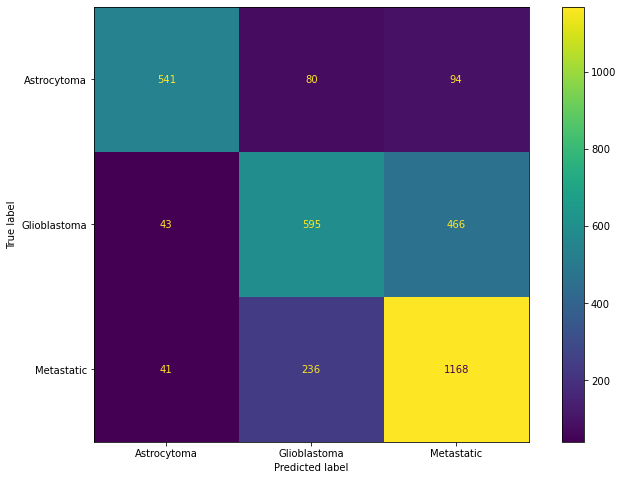

In [47]:
fig, ax = plt.subplots(figsize=(12, 8))
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label.inverse_transform(clf.classes_))
disp.plot(ax=ax)
plt.show()

In [49]:
for actual, pred in zip(label.inverse_transform(y_test)[:10], label.inverse_transform(y_pred)[:10]):
    if actual == pred:
        print(f"{actual}----{pred}")
    else:
        print(f"{actual}\t{pred}")

Glioblastoma----Glioblastoma
Metastatic----Metastatic
Astrocytoma----Astrocytoma
Metastatic----Metastatic
Glioblastoma----Glioblastoma
Glioblastoma----Glioblastoma
Metastatic----Metastatic
Astrocytoma----Astrocytoma
Metastatic----Metastatic
Glioblastoma	Metastatic
